# DCGAN
stands for Deep Covolutional Generative Adversarial Network

In [ ]:
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import time
import pandas as pd
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

# preprocess

`load_data`메서드의 `label`을 바꾸면 특정 레이블 이미지만 불러오기 가능(0은 모든 클래스의 이미지)

In [ ]:
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

train_x, test_x = load_data(label=8)

In [ ]:
train_x.shape

(5000, 32, 32, 3)

In [ ]:
train_x = (train_x - 127.5) / 127.5

In [ ]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [ ]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')

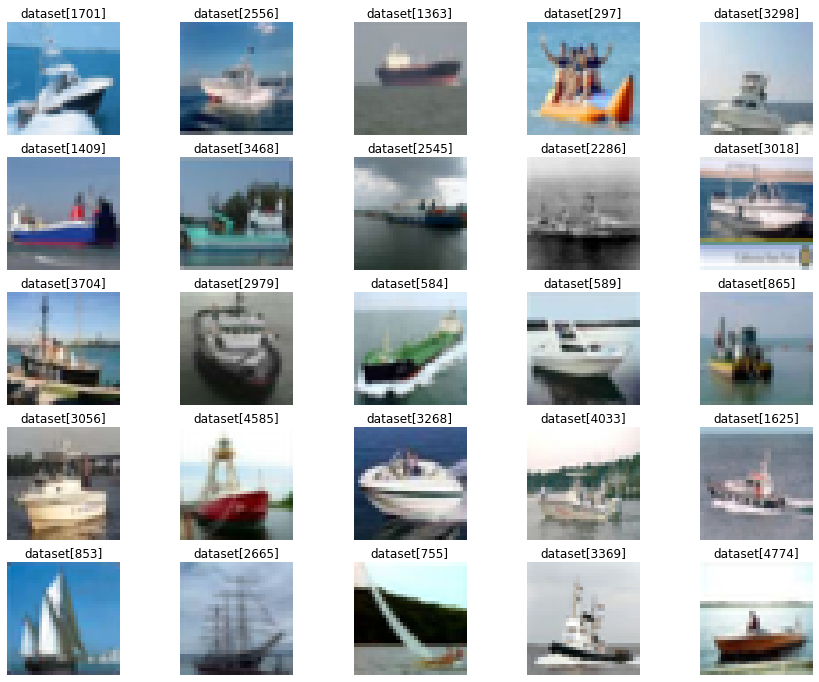

In [ ]:
plt.figure(figsize = (15, 12))

for i in range(25):
    idx = np.random.randint(train_x.shape[0])
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.array(train_x[i] * 127.5 + 127.5).astype('uint8'))
    plt.title(f'dataset[{idx}]')
    plt.axis('off')
plt.show()

In [ ]:
BUFFER_SIZE = train_x.shape[0]
BATCH_SIZE = 128

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BATCH_SIZE).batch(BATCH_SIZE)

# Model construction

## Generator

In [ ]:
def make_generator_model(noise_dim = 100):
    
    # 0.
    model = tf.keras.models.Sequential()
    
    # 1. dense
    model.add(tf.keras.layers.Dense(4 * 4 * 256, input_dim=noise_dim))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    # 2. reshape
    model.add(tf.keras.layers.Reshape((4, 4, 256)))
    
    # 3. conv2d transpose
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    # 4. conv2d transpose
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # upsample to 16x16
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    # 5. conv2d transpose
    model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # upsample to 32x32
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    # 6. conv2d transpose
    model.add(tf.keras.layers.Conv2D(3, (3,3), activation='tanh', padding='same'))
    
    return model  

In [ ]:
G = make_generator_model()

G.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        524416    
 ranspose)                                                       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

## Discriminator

In [ ]:
def make_discriminator_model():
    
    # 0.
    model = tf.keras.models.Sequential()
    
    # 1. conv2d
    model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(32, 32, 3)))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    # 2. conv2d
    model.add(tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')) # downsample
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    # 3. conv2d
    model.add(tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')) # downsample
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    # 4. conv2d
    model.add(tf.keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same')) # downsample
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    # 5. flatten
    model.add(tf.keras.layers.Flatten()) # classifier
    model.add(tf.keras.layers.Dropout(0.4))
    
    # 6. dense
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 
    
    return model

In [ ]:
D = make_discriminator_model()
D.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 256)        

In [ ]:
#logits=True: loss를 [0, 1]로 scaling하기 위함
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) 

## Loss
- Generator의 입장에서 `fake_output`이 1(`True`)에 가깝도록
- Discriminator의 입장에서
    - `real_output`은 1에 가깝게,
    - `fake_output`은 0(`False`)에 가깝게 학습하는 것이 바람직함
    - 두 loss를 더한 값을 `D_loss`로 저장


In [ ]:
def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

## Accuracy
- if `real_accuracy`
    - `== 0`: Discriminator 성능 부족
    - `== 1`: Generator 성능 부족

`real_accuracy == fake_accuracy == 0.5`: 이 경우, Discriminator가 진위여부를 운에 맡기므로, 성능 최고

In [ ]:
def D_acc(real_output, fake_output):
    real_acc = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_acc = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_acc, fake_acc

## Optimizer

In [ ]:
lr = 1e-4

In [ ]:
G_optim = tf.keras.optimizers.Adam(lr)
D_optim = tf.keras.optimizers.Adam(lr)

In [ ]:
num_examples_to_generate = 16
noise_dim = 100

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# Train step function
Decorator `@tf.function`활요

In [ ]:
@tf.function
def train_step(images, BATCH_SIZE=BATCH_SIZE, noise_dim=noise_dim): # 입력 데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])   # Generator 입력 노이즈

    with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape: # tf.GradientTape()
        gen_images = G(noise, training=True) # gen_image 생성

        # Discriminator 판별 과정
        real_output = D(images, training=True)   
        fake_output = D(gen_images)

        # Loss 계산
        gen_loss = G_loss(fake_output)
        disc_loss = D_loss(real_output, fake_output)

        # Accuracy 계산
        real_acc, fake_acc = D_acc(real_output, fake_output)

    # Gradient 계산
    G_grad = G_tape.gradient(gen_loss, G.trainable_variables)
    D_grad = D_tape.gradient(disc_loss, D.trainable_variables)

    # 모델 학습
    G_optim.apply_gradients(zip(G_grad, G.trainable_variables))
    D_optim.apply_gradients(zip(D_grad, D.trainable_variables))

    return gen_loss, disc_loss, real_acc, fake_acc

## 학습 관찰 샘플 함수

In [ ]:
def gen_and_save_img(model, epoch, iter, sample_seeds):

    pred = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(pred.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(pred[i, :, :, :])
        plt.axis("off")

    plt.savefig('/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, iter))

    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6 # Matlab 차트의 기본 크기를 15, 6으로 지정

def draw_train_history(history, epoch):
    # Loss history를 요약
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper_left')

    # Accuracy history 요약
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  

    # training_history 디렉토리에 epoch별 그래프를 gif 형태로 저장
    plt.savefig('/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

## Checkpoint 선언

In [ ]:
ckpt_dir = '/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/training_checkpoints'

ckpt_prefix = os.path.join(ckpt_dir, "ckpt")
ckpt = tf.train.Checkpoint(generator_optimizer=G_optim,
                           discriminator_optimizer=D_optim,
                           generator=G,
                           discriminator=D)

## 학습 함수

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for iter, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if iter % 50 == 0:
                display.clear_output(wait=True)
                gen_and_save_img(G, epoch + 1, iter + 1, seed)
                print('Epoch {} | iter {}'.format(epoch + 1, iter + 1))
                print('Time for epoch {} : {} sec'.format(epoch + 1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            ckpt.save(file_prefix=ckpt_prefix)

        display.clear_output(wait=True)
        gen_and_save_img(G, epochs, iter, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)        

In [ ]:
save_every = 5
EPOCHS = 1000

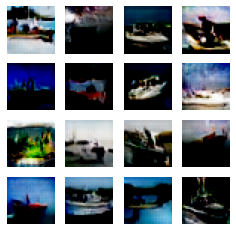

Time for training : 3956 sec


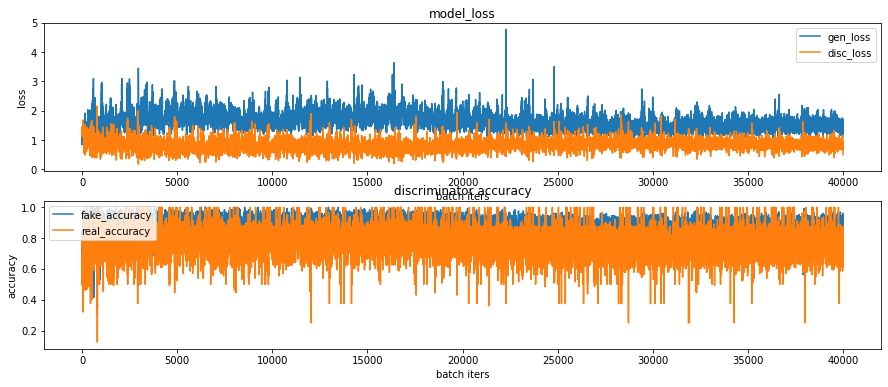

CPU times: user 48min 5s, sys: 1min 34s, total: 49min 40s
Wall time: 1h 5min 59s


In [ ]:
%%time
train(train_ds, EPOCHS, save_every)

In [ ]:
anim_file = '/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
filenames = glob.glob('/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/generated_samples/sample*.png')
filenames

['/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/generated_samples/sample_epoch_0001_iter_001.png',
 '/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/generated_samples/sample_epoch_0300_iter_039.png',
 '/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/generated_samples/sample_epoch_0002_iter_001.png',
 '/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/generated_samples/sample_epoch_0003_iter_001.png',
 '/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/generated_samples/sample_epoch_0004_iter_001.png',
 '/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/generated_samples/sample_epoch_0005_iter_001.png',
 '/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/generated_samples/sample_epoch_0006_iter_001.png',
 '/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/generated_samples/sample_epoch_0007_iter_001.png',
 '/content/drive/MyDrive/aiffel_FT/LMS/dcgan_newimage/fashion/generated_samples/sample_epoch_000

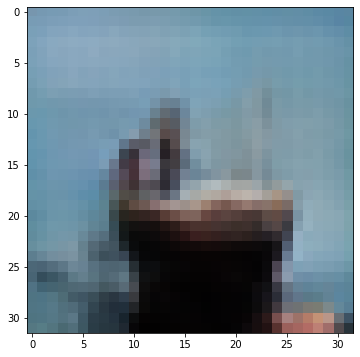

In [ ]:
ckpt_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(ckpt_dir)
ckpt.restore(latest)

generator = ckpt.generator
discriminator = ckpt.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.